Process the results from gRodon output (07_gRodon_command_R) and compare it against O2 consumption rates

### Citation 
Weissman JL, Hou S, Fuhrman JA. 2020. Estimating maximal microbial growth rates from cultures, metagenomes, and single cells via codon usage patterns. bioRxiv 118:1–10.

rerun on 2021-12-07 after correcting for salinity of media samples

In [21]:
import pandas as pd
from pandas import DataFrame
import os
import sys
import csv
from pathlib import Path
import seaborn as sns
sns.set()
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.show()
from collections import defaultdict
import os.path as op
import glob
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

os.chdir('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/gRodon')
outdir='/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/gRodon/'
images='/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_images/gRodon/'
matplotlib.__version__

'3.3.3'

rerun on 2021-12-07 after correcting for salinity of media samples

In [22]:

growth=pd.read_csv('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/gRodon/gRodon_SAG_growth_rate.csv',
                  index_col=0)
# limit output to only the SAGs with at least 10 ribosomal genes
# the base of 10 was determined in the original paper
growth=growth[growth['N_Highly_expressed'] >=10 ]
growth

,CUBHE,ConsistencyHE,CPB,FilteredSequences,d,LowerCI,UpperCI,SAG,Total_genes,N_Highly_expressed
1,0.481754,0.458151,-0.353868,39,7.886061,5.654089,11.181332,AH-700-A01,386,11
3,0.659937,0.556610,-0.397104,71,5.597246,4.385050,7.207158,AH-700-A04,1235,25
5,0.571012,0.533397,-0.321668,113,9.973973,7.727288,12.997506,AH-700-A06,1921,37
7,0.517372,0.470010,-0.374567,21,6.518627,4.941387,8.696994,AH-700-A08,362,27
9,0.639133,0.503667,-0.325440,149,3.203031,2.751461,3.741179,AH-700-A11,1812,17
...,...,...,...,...,...,...,...,...,...,...
4736,0.512274,0.471677,-0.411051,50,7.052606,5.326387,9.447291,AH-578-P14,707,32
4738,0.651424,0.510320,-0.425999,73,3.129511,2.702134,3.635787,AH-578-P17,868,20
4740,0.657172,0.545528,-0.379596,154,4.883639,3.965807,6.051991,AH-578-P20,1954,41
4741,0.531994,0.502735,-0.375404,27,9.319359,7.263922,12.065735,AH-578-P21,438,18


In [23]:
columns=['name', 'Predicted_respiration_rate_fmol_O2perhr', 'GTDB_classification', 'FACS_date', 'Sample_collection_Date', 'gate']
SAG_data=pd.read_csv('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/Summary_files/All_GoM_SAGs_1cell_20kb_decon_531normalized_predresp_rate_GTDBclass.csv',
                     usecols=columns)

SAG_data

,name,Sample_collection_Date,FACS_date,gate,Predicted_respiration_rate_fmol_O2perhr,GTDB_classification
0,AH-135-A01,170412,170412,Respiring cells (RSG-positive),0.004610,Pelagibacter
1,AH-135-A02,170412,170412,Respiring cells (RSG-positive),0.063356,Hel1-33-131
2,AH-135-A03,170412,170412,Respiring cells (RSG-positive),0.004335,IMCC9063
3,AH-135-A04,170412,170412,Respiring cells (RSG-positive),0.019320,Thioglobus
4,AH-135-A05,170412,170412,Respiring cells (RSG-positive),0.007375,SCGC-AAA076-P13
...,...,...,...,...,...,...
5845,AH-273-P18,171102,171102,All prokaryotes (SYTO-9-positive),NaN,MAG-121220-bin8
5846,AH-273-P19,171102,171102,All prokaryotes (SYTO-9-positive),NaN,UBA3537
5847,AH-273-P20,171102,171102,All prokaryotes (SYTO-9-positive),NaN,Pelagibacter_A
5848,AH-273-P22,171102,171102,All prokaryotes (SYTO-9-positive),NaN,Pelagibacter


In [24]:
classification=SAG_data[['name', 'GTDB_classification']].copy()
growth_rate=growth.merge(classification, left_on='SAG', right_on='name', how='left')
growth_rate=growth_rate[growth_rate['GTDB_classification'].notna()]
avg_growth=growth_rate.pivot_table(values='d', index='GTDB_classification', aggfunc=np.mean)
avg_growth=avg_growth.rename(columns={'d':'Average_doubling_time'})

avg_growth

,Average_doubling_time
GTDB_classification,
AAA164-E04,12.755643
AAA536-G10,10.508890
AG-337-I02,9.321011
AG-339-G14,10.250614
AG-414-E02,9.136331
...,...
Unclassified,4.165118
Verrucomicrobiales,2.124219
Vicingaceae,4.464510


In [25]:
median_growth=growth_rate.pivot_table(values='d', index='GTDB_classification', aggfunc=np.median)
median_growth=median_growth.rename(columns={'d':'median_doubling_time'})
median_growth


,median_doubling_time
GTDB_classification,
AAA164-E04,12.456005
AAA536-G10,10.541393
AG-337-I02,9.504926
AG-339-G14,10.250614
AG-414-E02,9.136331
...,...
Unclassified,3.478185
Verrucomicrobiales,2.124219
Vicingaceae,4.464510


In [26]:
SAG_data=SAG_data[SAG_data['Predicted_respiration_rate_fmol_O2perhr'].notna()]
SAG_data=SAG_data[SAG_data['Sample_collection_Date']==SAG_data['FACS_date']]

SAG_data=SAG_data[SAG_data['Sample_collection_Date']!=170412]
SAG_data=SAG_data[SAG_data['Sample_collection_Date']!=170818]
SAG_data=SAG_data[SAG_data['Sample_collection_Date']!=171102]
SAG_data


,name,Sample_collection_Date,FACS_date,gate,Predicted_respiration_rate_fmol_O2perhr,GTDB_classification
1964,AH-545-A01,181030,181030,Respiring cells (RSG-positive),0.004897,HIMB59
1965,AH-545-A02,181030,181030,Respiring cells (RSG-positive),0.045645,UBA5951
1966,AH-545-A03,181030,181030,Respiring cells (RSG-positive),0.014962,Unclassified
1967,AH-545-A04,181030,181030,Respiring cells (RSG-positive),0.004827,Thioglobus_A
1968,AH-545-A05,181030,181030,Respiring cells (RSG-positive),0.003989,Thioglobus
...,...,...,...,...,...,...
4728,AH-700-P10,190709,190709,Respiring cells (RSG-positive),0.068309,Planktomarina
4729,AH-700-P11,190709,190709,Respiring cells (RSG-positive),0.003930,Luminiphilus
4730,AH-700-P13,190709,190709,Respiring cells (RSG-positive),0.029714,Planktomarina
4731,AH-700-P14,190709,190709,Respiring cells (RSG-positive),0.007228,UBA8649


In [27]:
growth_data=growth.merge(SAG_data, left_on='SAG', right_on='name', how='inner')
growth_data=growth_data[growth_data['Predicted_respiration_rate_fmol_O2perhr'].notna()]
growth_data['log10_fmol_O2_consumption_per_cell_perhr']=np.log10(growth_data['Predicted_respiration_rate_fmol_O2perhr'])
growth_data

,CUBHE,ConsistencyHE,CPB,FilteredSequences,d,LowerCI,UpperCI,SAG,Total_genes,N_Highly_expressed,name,Sample_collection_Date,FACS_date,gate,Predicted_respiration_rate_fmol_O2perhr,GTDB_classification,log10_fmol_O2_consumption_per_cell_perhr
0,0.481754,0.458151,-0.353868,39,7.886061,5.654089,11.181332,AH-700-A01,386,11,AH-700-A01,190709,190709,Respiring cells (RSG-positive),0.003871,Pelagibacter,-2.412158
1,0.659937,0.556610,-0.397104,71,5.597246,4.385050,7.207158,AH-700-A04,1235,25,AH-700-A04,190709,190709,Respiring cells (RSG-positive),0.004395,BACL21,-2.357039
2,0.571012,0.533397,-0.321668,113,9.973973,7.727288,12.997506,AH-700-A06,1921,37,AH-700-A06,190709,190709,Respiring cells (RSG-positive),0.003926,GCA-002712045,-2.406080
3,0.517372,0.470010,-0.374567,21,6.518627,4.941387,8.696994,AH-700-A08,362,27,AH-700-A08,190709,190709,Respiring cells (RSG-positive),0.005455,MAG-121220-bin8,-2.263233
4,0.639133,0.503667,-0.325440,149,3.203031,2.751461,3.741179,AH-700-A11,1812,17,AH-700-A11,190709,190709,Respiring cells (RSG-positive),0.051475,Planktomarina,-1.288402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0.566388,0.513212,-0.353584,117,7.603080,6.122478,9.506576,AH-545-P15,1722,19,AH-545-P15,181030,181030,Respiring cells (RSG-positive),0.015815,Thioglobus,-1.800942
443,0.632980,0.545138,-0.392584,107,6.201829,4.951652,7.825365,AH-545-P17,907,10,AH-545-P17,181030,181030,Respiring cells (RSG-positive),0.027636,UBA10347,-1.558529
444,0.524821,0.482502,-0.374546,50,7.310364,5.653807,9.544337,AH-545-P19,649,13,AH-545-P19,181030,181030,Respiring cells (RSG-positive),0.004118,Pelagibacter,-2.385314
445,0.529079,0.506113,-0.407082,83,10.162536,7.863351,13.261407,AH-545-P20,960,35,AH-545-P20,181030,181030,Respiring cells (RSG-positive),0.004161,TMED189,-2.380824


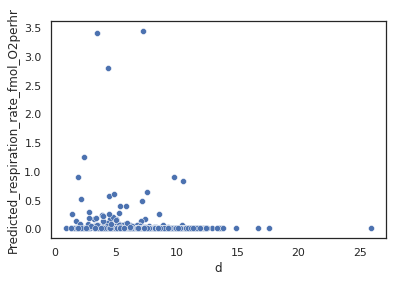

In [28]:
sns.set_style("white")
fig=sns.scatterplot(data=growth_data, x='d', y='Predicted_respiration_rate_fmol_O2perhr')
save=fig.get_figure()
save.savefig(images+'SAG_gRodon_doubling_time_v_O2_resipration'+".pdf")

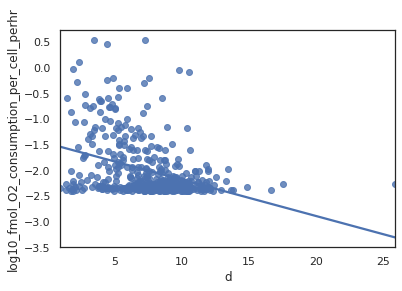

In [29]:
fig2=sns.regplot(data=growth_data, x='d', y='log10_fmol_O2_consumption_per_cell_perhr', ci=None)
save=fig2.get_figure()
save.savefig(images+'SAG_gRodon_doubling_time_v_logO2_resipration_individual_SAGs'+".pdf")

In [30]:


X = pd.DataFrame(growth_data['d'])
y = pd.DataFrame(growth_data['log10_fmol_O2_consumption_per_cell_perhr'])
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)


[-0.09526943376700281, 0.0907554999638881, 0.1887933028796649]


## Regression is not a great fit. WHat if I tried averaging across the genus. aka one point per genus instead of one point per cell. I could use the average weighted O2 consumption value and calculate an average d for each genus using a file from earlier

In [31]:

genus_O2=pd.read_csv('/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/O2_consumption/Weighted_average_O2_consumption_per_cell_per_genus.csv',
                    index_col=0)
O2_melt=genus_O2.pivot(index='genus', values='Weighted_avg_O2_consumed_per_cell', columns='date')
genus_O2_melt=pd.DataFrame()
genus_O2_melt['average_O2_consumption_per_cell']=O2_melt.mean(axis=1)
genus_O2_melt['median_O2_consumption_per_cell']=O2_melt.median(axis=1)
genus_O2_melt
genus_O2

,genus,Weighted_avg_O2_consumed_per_cell,date
0,AAA164-E04,0.002330,20171102
1,AAA536-G10,0.002330,20171102
2,AG-337-I02,0.002330,20171102
3,AG-414-E02,0.002330,20171102
4,AG-422-B15,0.002330,20171102
...,...,...,...
663,Verrucomicrobiales,0.001999,20190709
664,Vibrio,0.001999,20190709
665,Vicingaceae,0.001999,20190709
666,Winogradskyella,0.001999,20190709


In [32]:
genus_growth_rate=avg_growth.merge(median_growth, on='GTDB_classification')
genus_growth_rate=genus_growth_rate.reset_index()

genus_growth_rate=genus_growth_rate.merge(genus_O2_melt, left_on='GTDB_classification', right_on='genus', how='left')
genus_growth_rate['log10_average_O2_consumption_per_cell']=np.log10(genus_growth_rate['average_O2_consumption_per_cell'])
genus_growth_rate['log10_median_O2_consumption_per_cell']=np.log10(genus_growth_rate['median_O2_consumption_per_cell'])
genus_growth_rate

,GTDB_classification,Average_doubling_time,median_doubling_time,average_O2_consumption_per_cell,median_O2_consumption_per_cell,log10_average_O2_consumption_per_cell,log10_median_O2_consumption_per_cell
0,AAA164-E04,12.755643,12.456005,0.002120,0.002075,-2.673700,-2.682931
1,AAA536-G10,10.508890,10.541393,0.002853,0.002693,-2.544683,-2.569765
2,AG-337-I02,9.321011,9.504926,0.003928,0.002215,-2.405783,-2.654560
3,AG-339-G14,10.250614,10.250614,NaN,NaN,NaN,NaN
4,AG-414-E02,9.136331,9.136331,0.002120,0.002075,-2.673700,-2.682931
...,...,...,...,...,...,...,...
211,Unclassified,4.165118,3.478185,5.954454,0.233916,0.774842,-0.630940
212,Verrucomicrobiales,2.124219,2.124219,0.002120,0.002075,-2.673700,-2.682931
213,Vicingaceae,4.464510,4.464510,0.002120,0.002075,-2.673700,-2.682931
214,Winogradskyella,4.283599,4.356637,0.002120,0.002075,-2.673700,-2.682931


In [33]:
rates=genus_growth_rate[['GTDB_classification', 'Average_doubling_time', 'median_doubling_time']].copy()
rates=rates.rename(columns={'GTDB_classification':'genus'})
rates.to_csv('genus_doubling_rates.csv')
rates

,genus,Average_doubling_time,median_doubling_time
0,AAA164-E04,12.755643,12.456005
1,AAA536-G10,10.508890,10.541393
2,AG-337-I02,9.321011,9.504926
3,AG-339-G14,10.250614,10.250614
4,AG-414-E02,9.136331,9.136331
...,...,...,...
211,Unclassified,4.165118,3.478185
212,Verrucomicrobiales,2.124219,2.124219
213,Vicingaceae,4.464510,4.464510
214,Winogradskyella,4.283599,4.356637


In [34]:
genus_O2_growth=genus_O2.merge(rates, on='genus')
genus_O2_growth['log10_weighted_avg_O2_consumed']=np.log10(genus_O2_growth['Weighted_avg_O2_consumed_per_cell'])
genus_O2_growth

,genus,Weighted_avg_O2_consumed_per_cell,date,Average_doubling_time,median_doubling_time,log10_weighted_avg_O2_consumed
0,AAA164-E04,0.002330,20171102,12.755643,12.456005,-2.632640
1,AAA164-E04,0.002050,20181030,12.755643,12.456005,-2.688282
2,AAA164-E04,0.002101,20190402,12.755643,12.456005,-2.677645
3,AAA164-E04,0.001999,20190709,12.755643,12.456005,-2.699231
4,AAA536-G10,0.002330,20171102,10.508890,10.541393,-2.632640
...,...,...,...,...,...,...
619,Winogradskyella,0.001999,20190709,4.283599,4.356637,-2.699231
620,Yoonia,0.002330,20171102,2.271783,1.606194,-2.632640
621,Yoonia,0.002050,20181030,2.271783,1.606194,-2.688282
622,Yoonia,0.002101,20190402,2.271783,1.606194,-2.677645


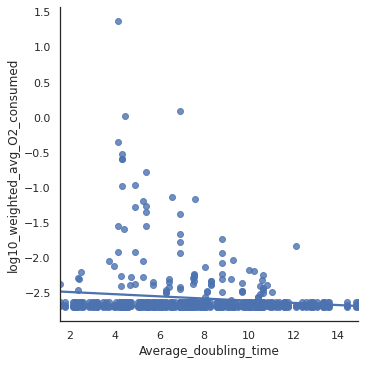

In [35]:
average=sns.lmplot(data=genus_O2_growth, x='Average_doubling_time', y='log10_weighted_avg_O2_consumed', ci=None)
#save=average.get_figure()
average.savefig(images+'gRodon_doubling_time_v_log_weighted_avg_O2_consumed_per_genus.pdf')

## Should I consider getting rid of all the genera that I never detected in the "above detection" fraction?

There does seem to be at least some negative correlation between the two. Even though almost all of the genera would be considered "slow growing" by the gRodon paper and the accuracy is lower there does seem to be a trend of higher O2 consuming species/cells have lower doubling times

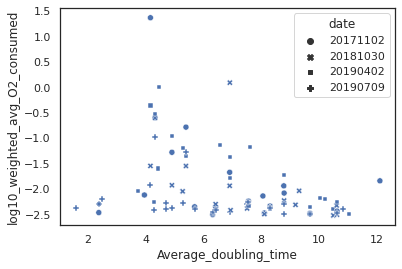

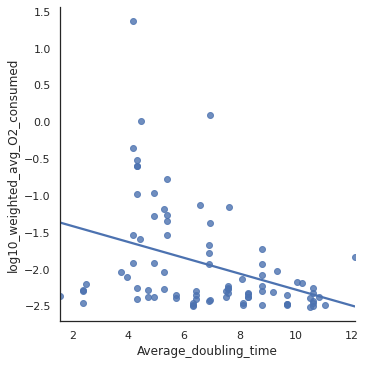

In [36]:
outdir='/mnt/scgc/simon/microg2p/analyses/20210325_GoM_recluster/20210325_GoM_recluster_analysis/O2_consumption/'
genus_O2_growth=genus_O2_growth[genus_O2_growth['Weighted_avg_O2_consumed_per_cell'] >=0.003]
genus_O2_growth

abovedetection=sns.scatterplot(data=genus_O2_growth, x='Average_doubling_time', y='log10_weighted_avg_O2_consumed', ci=None, style='date')
save=abovedetection.get_figure()
save.savefig(images+'gRodon_doubling_time_v_log_weighted_avg_O2_consumed_above_detection_per_genus_scatter.pdf')

abovedetection=sns.lmplot(data=genus_O2_growth, x='Average_doubling_time', y='log10_weighted_avg_O2_consumed', ci=None)
#save=abovedetection.get_figure()
abovedetection.savefig(images+'gRodon_doubling_time_v_log_weighted_avg_O2_consumed_above_detection_per_genus.pdf')

In [37]:
X = pd.DataFrame(genus_O2_growth['Average_doubling_time'])
y = pd.DataFrame(genus_O2_growth['log10_weighted_avg_O2_consumed'])
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[-0.4771430685823328, 0.038886234642638295, 0.04367420212351392]


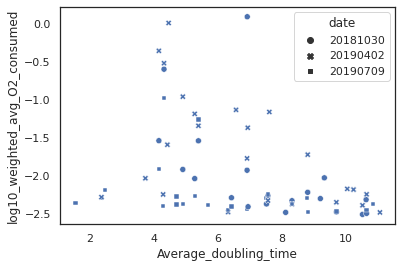

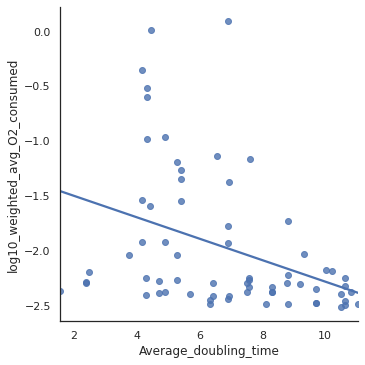

In [38]:
genus_O2_growth=genus_O2_growth[genus_O2_growth['date'] !=20171102]
genus_O2_growth

abovedetection=sns.scatterplot(data=genus_O2_growth, x='Average_doubling_time', y='log10_weighted_avg_O2_consumed', ci=None, style='date')
save=abovedetection.get_figure()
save.savefig(images+'gRodon_doubling_time_v_log_weighted_avg_O2_consumed_above_detection_per_genus_scatter_NO2017.pdf')

abovedetection=sns.lmplot(data=genus_O2_growth, x='Average_doubling_time', y='log10_weighted_avg_O2_consumed', ci=None)
#save=abovedetection.get_figure()
abovedetection.savefig(images+'gRodon_doubling_time_v_log_weighted_avg_O2_consumed_above_detection_per_genus_NO2017.pdf')

In [39]:
X = pd.DataFrame(genus_O2_growth['Average_doubling_time'])
y = pd.DataFrame(genus_O2_growth['log10_weighted_avg_O2_consumed'])
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)


[0.11621733882137074, 0.20349704774242994, 0.022756892580304888]


In [40]:
genus_O2_growth.to_csv(outdir+'gRodon_mininum_doublingtimes_')